# rnn-text-classification
- 调试须知：python中的函数不到调用不会检查 即便有拼写等错误

## prepocessiong
- 分词
- 词语 -> id
    - 由于：matrix -> [|V|, embed_size]
    - 词表 从而得到词语的id表示(词语A -> id(5))
- label -> id

In [1]:
import sys
import os
import jieba
import tensorflow as tf
import numpy as np
import math

In [17]:
# input files
train_file = './text_classification/cnews.train.txt'
val_file = './text_classification/cnews.val.txt'
test_file = './text_classification/cnews.test.txt'
#output files
seg_train_file = './text_classification/cnews.train.seg.txt'
seg_val_file = './text_classification/cnews.val.seg.txt'
seg_test_file = './text_classification/cnews.test.seg.txt'

vocab_file = './text_classification/cnews.vocab.txt'
category_file = './text_classification/cnews.category.txt'

### file read demo

In [ ]:

'''通过bytes-like对象读取
with open(test_file,'rb') as f:
    lines = f.readlines()
label,content = lines[0].decode('utf-8').strip('\r\n').split('\t')
'''
'''直接在读取的时候指定读取的编码'''
with open(test_file,'r',encoding='utf-8') as f:
    lines = f.readlines()
label,content = lines[0].strip('\r\n').split('\t')
'''如果以上两种都不用 报错 'gbk' codec can't decode意思是无法通过gbk进行解码
原因是文本本身不是gbk 所以无法用默认的gbk方式解码 
所以最直接的通过相应格式进行文件读取
/使用读取字节文件方式读取 之后再对读取内容进行解码
'''
words = jieba.cut(content)
print(content)
print(' '.join(words))

### 断句 分词

In [14]:
def segment_file(input_file,output_file):
    '''segment the sentences in each line from the inputfile'''
    with open(input_file,'r',encoding='utf-8') as f:
        lines = f.readlines()
    with open(output_file,'w',encoding='utf-8') as f:
        for line in lines:
            label,content = line.strip('\r\n').split('\t')
            words = jieba.cut(content)
            content_by_word = ''
            for word in words:
                word.strip(' ')
                if word != '':
                    content_by_word += word+' '
            out_line = '%s\t%s\n'%(label,content_by_word.strip(' '))
            f.write(out_line)
segment_file(train_file,seg_train_file)
segment_file(val_file,seg_val_file)
segment_file(test_file,seg_test_file)

### 生成词表 类表
- 行号索引是id
- 后面接上次数 便于后续处理 以及观察分布信息

In [15]:
def generate_vocab_file(input_seg_file,output_vocab_file):
    with open(input_seg_file,'r',encoding='utf-8') as f:
        lines = f.readlines()
    word_dict = {} # 统计词频
    for line in lines:
        label,content = line.strip('\r\n').split('\t')
        for word in content.split():
            # 如果没有这个key设置为0
            word_dict.setdefault(word,0)
            word_dict[word] += 1 
    # 按照频率进行排序 使用lambda函数对于元祖列表排序制定关键字
    sorted_word_dict = sorted(word_dict.items(),
                             key=lambda word:word[1],reverse=True)
    with open(output_vocab_file,'w',encoding='utf-8') as f:
        '''
        写入未知字符标识
        1:对于舍掉不常用的词可以再train中使用这个作为id
        2:对于val / test中出现的train中没有的可以用这个作为id
        3:对于不足threshold长度的sentence可以使用这个进行补齐
        '''
        f.write('<UNK>\t100000000\n')
        for item in sorted_word_dict:
            f.write('%s\t%d\n' % item)
generate_vocab_file(seg_train_file,vocab_file)

In [23]:
def generate_category_file(input_file,output_category_file):
    with open(input_file,'r',encoding='utf-8') as f:
        lines = f.readlines()
    category_dict = {} # 统计词频
    for line in lines:
        label,content = line.strip('\r\n').split('\t')
        category_dict.setdefault(label,0)
        category_dict[label] += 1 
    # 按照频率进行排序 使用lambda函数对于元祖列表排序制定关键字
    sorted_category_dict = sorted(category_dict.items(),
                             key=lambda c:c[1],reverse=True)
    with open(output_category_file,'w',encoding='utf-8') as f:
        for item in sorted_category_dict:
            print('%s\t%d\n' % item)
            f.write('%s\n' % item[0])
            
generate_category_file(train_file,category_file)

体育	5000

娱乐	5000

家居	5000

房产	5000

教育	5000

时尚	5000

时政	5000

游戏	5000

科技	5000

财经	5000



## 数据集封装 + 超参数定义
- next_batch api 
    - read seg file get sentences id and category id by vocab and category class
- 词表封装
    - wordtoid api
- 类别表封装
    - categorytoid api

### 超参数定义(by HParams+tf logging output)

In [86]:
tf.logging.set_verbosity(tf.logging.INFO)

def get_default_param():
    """
    return HParams object to get hyper parameters
    可以通过构造方法传入参数 通过对象直接访问参数
    """
    return tf.contrib.training.HParams(
        num_embedding_size = 16,#embedding length
        num_timesteps = 50,#用于batch内对齐 也可以不对齐 但是这样方便cnn
        num_lstm_nodes = [64,64],
        num_lstm_layers = 2,
        num_fc_nodes = 32,
        batch_size = 100,
        learning_rate = 1e-3,
        num_word_threshold = 20,#超过这个长度额截断 不足补齐
        # 防止梯度爆炸 梯度消失可以用lstm特性避免一部分
        clip_lstm_grads = 1.0,# 控制梯度不超过1.0
    )
hps = get_default_param()

# 定义需要用到的w文件
train_seg_file = './text_classification/cnews.train.seg.txt'
val_seg_file = './text_classification/cnews.val.seg.txt'
test_seg_file = './text_classification/cnews.test.seg.txt'
vocab_file = './text_classification/cnews.vocab.txt'
category_file = './text_classification/cnews.category.txt'

output_folder = './text_classification/run_text_rnn'
if not os.path.exists(output_folder):
    os.mkdir(output_folder)
    

### 词表封装
- 实现sentencetoid api

In [35]:
class Vocab:
    def __init__(self,filename,num_word_threshold):
        self._num_word_threshold = num_word_threshold
        self._unk = -1
        self._word_to_id_dict = {}
        self._read_file(filename)
    def _read_file(self,filename):
        with open(filename,'r',encoding='utf-8') as f:
            lines = f.readlines()
        for line in lines:
            word,freq = line.strip('\r\n').split('\t')
            freq = int(freq)
            if freq < self._num_word_threshold:
                continue
            nowid = len(self._word_to_id_dict)
            if word == '<UNK>':
                self._unk = nowid
            self._word_to_id_dict[word] = nowid
    def _word_to_id(self,word):
        '''没有的返回unk的id'''
        return self._word_to_id_dict.get(word,self._unk)
    
    # 使用property 可以像获取公开成员方式访问函数
    @property
    def unk(self):
        return self._unk
    
    def get_size(self):
        return len(self._word_to_id_dict)
    def sentence_to_id(self,seg_sentence):
        word_ids = [self._word_to_id(w) for w in seg_sentence.split()]
        return word_ids
    
class Category:
    def __init__(self,filename):
        self._category_to_id_dict = {}
        self._read_file(filename)
        
    def _read_file(self,filename):
        with open(filename,'r',encoding='utf-8') as f:
            lines = f.readlines()
        for line in lines:
            category = line.strip('\r\n')
            nowid = len(self._category_to_id_dict)
            self._category_to_id_dict[category] = nowid
    
    def get_size(self):
        return len(self._category_to_id_dict)
    
    def category_to_id(self,category_name):
        if not category_name in self._category_to_id_dict.keys():
            raise Exception(
                "%s is not in our category list" % category_name)
        return self._category_to_id_dict[category_name]
    
vocab = Vocab(vocab_file,hps.num_word_threshold)
'''size 在后续的网络搭建中会用到'''
vocab_size = vocab.get_size()

category = Category(category_file)
num_classes = category.get_size()

tf.logging.info('classes_num is:%d\n'%num_classes)
demo_str = '体育'
tf.logging.info('label is:%s\t id is:%s\n' % \
                (demo_str,category.category_to_id(demo_str)))

INFO:tensorflow:classes_num is:10

INFO:tensorflow:label is:体育	 id is:0



### dataset

In [38]:
class TextClassificationDataSet:
    def __init__(self,filename,vocab,category,num_timesteps,need_shuffle=True):
        """
        提供next_batch 并且需要通过num_timesteps 得到batch中的语句词语数目
        便于对齐
        """
        self._vocab = vocab
        self._category = category
        self._num_timesteps = num_timesteps
        self._need_shuffle = need_shuffle
        '''data is id matrix,label is id vector'''
        self._datas = []
        self._labels = []
        self._indicator = 0
        self._parse_file(filename)
    def _parse_file(self,filename):
        tf.logging.info('loading data from %s' % filename)
        with open(filename,'r',encoding='utf-8') as f:
            lines = f.readlines()
        for line in lines:
            label,content = line.strip('\r\n').split('\t')
            id_label = self._category.category_to_id(label)
            id_content = self._vocab.sentence_to_id(content)
            '''进行对齐长度处理(尽可能少用if)'''
            id_content = id_content[0:self._num_timesteps]
            padding_num = self._num_timesteps - len(id_content)
            id_content = id_content + [self._vocab.unk for i in range(padding_num)]
            self._datas.append(id_content)
            self._labels.append(id_label)
        '''切记对于从文本中读取的数字是str 需要转换成int类型 ?在tf中可以自动转换为float32'''
        self._datas = np.asarray(self._datas,dtype=np.int32)
        self._labels = np.asarray(self._labels,dtype=np.int32)
        '''首次生成需要random shuffle'''
        self._random_shuffle()
        
    def next_batch(self,batch_size):
        # 默认参数的值不能是init声明的成员变量吗??
        if batch_size > len(self._datas):
            raise Execption("batch_size: %d is too large" % batch_size)        
        end_indicator = self._indicator + batch_size
        if end_indicator > len(self._datas):
            if self._need_shuffle:
                self._random_shuffle()
            self._indicator = 0
            end_indicator = batch_size
        
        batch_datas = self._datas[self._indicator:end_indicator]
        batch_labels = self._labels[self._indicator:end_indicator]
        self._indicator = end_indicator
        return batch_datas,batch_labels
    
    def _random_shuffle(self):
        idx = np.random.permutation(len(self._datas))
        self._datas = self._datas[idx]
        self._labels = self._labels[idx]

train_dataset = TextClassificationDataSet(train_seg_file,vocab,
                                          category,hps.num_timesteps)
val_dataset = TextClassificationDataSet(val_seg_file,vocab,category,
                                        hps.num_timesteps,False)
test_dataset = TextClassificationDataSet(test_seg_file,vocab,category,
                                         hps.num_timesteps,False)

print(train_dataset.next_batch(1))
print(val_dataset.next_batch(1))
print(test_dataset.next_batch(1))


INFO:tensorflow:loading data from ./text_classification/cnews.train.seg.txt
INFO:tensorflow:loading data from ./text_classification/cnews.val.seg.txt
INFO:tensorflow:loading data from ./text_classification/cnews.test.seg.txt
(array([[ 3605,  7358,  3875,    43,   138,   613,   101,    23,  1988,
         6006,    76,     0,  1631,  3605,    43,   744,  1533,   282,
            1,    22,    26,   637,  3605,  7358,  3875,    43,    84,
          261,    27,   639,   101,   336,  1988,     1,   555,   101,
         3335,    43,  2118,  2614,   163, 32141,     0,   132,     1,
         3026, 24531,     5, 31582,    28]]), array([9]))
(array([[  402,   143,    67,   627,     0,  3693,  9894,  4113,   672,
         1861,  1416,   153,    23,   503,   814,   160,   402,  3606,
        10705,  4230,   334,     1,   451,   103, 11386,  1192,   174,
          627,     0,  3693,   672,     1,  3752,   247,  4682,   627,
           62, 26217, 10187,  9496,   673, 12139,     1,   171,    68,
     

## create model
- 这里仅仅搭建最简单的show and tell model by basiclstm and dynamicrnn
- 众多初始化函数教程 
    - https://www.cnblogs.com/denny402/p/6932956.html
    
- tf.glorot_uniform_initializer()
    - 也称之为Xavier uniform initializer，由一个均匀分布（uniform distribution)来初始化数据。
    - 假设均匀分布的区间是[-limit, limit],则
    - limit=sqrt(6 / (fan_in + fan_out))
    - 其中的fan_in和fan_out分别表示输入单元的结点数和输出单元的结点数。
- glorot_normal_initializer（）
    - 也称之为 Xavier normal initializer. 由一个 truncated normal distribution来初始化数据.
    - stddev = sqrt(2 / (fan_in + fan_out))
    - 其中的fan_in和fan_out分别表示输入单元的结点数和输出单元的结点数。
    
> 以上两者很多地方是tf默认的intializer

- 损失函数学习
    - https://zihuaweng.github.io/2018/04/01/loss/
- 声明cell    
    - tf.contrib.nn.... -> tf.nn.rnn_cell.BasicLSTMCell/BasicRNNCell
    - tf.nn.rnn_cell.MultiRNNCell(\[cells\])
    - tf.nn.rnn_cell.GRUCell
    - tf.nn.rnn_cell.DropoutWrapper
    - tf.nn.rnn_cell.LSTMCell/RNNCell
- 调用cell
    - cell.call(input,state) 一次执行一步 
    - tf.nn.dynamic_rnn(cell, inputs, initial_state=initial_state) 一次执行多步

In [87]:
'''edition 1 使用原有的lstmcell'''
def create_model(hps,vocab_size,num_classes):
    """
    需要生成embedding矩阵 就是[vocab_size,num_embedding_size]
    输出为num_classes 分类器输出
    """
    num_timesteps = hps.num_timesteps
    batch_size = hps.batch_size
    
    inputs = tf.placeholder(tf.int32,(batch_size,num_timesteps))
    outputs = tf.placeholder(tf.int32,(batch_size,))
    keep_prob = tf.placeholder(tf.float32,name='dropout_keep_prob')
    print(inputs.get_shape().as_list())

    '''使用variable_scope 可以指定初始化函数'''
    '''input_layer'''
    embedding_initializer = tf.random_uniform_initializer(-1.0,1.0)
    with tf.variable_scope('embedding',initializer=embedding_initializer):
        embeddings = tf.get_variable('vocab_embedding_matrix',
                                    [vocab_size,hps.num_embedding_size],
                                    tf.float32)
        '''将id索引序列转换为对应的embedding中的embed_vector tf.nn.embedding_lookup'''
        embed_inputs = tf.nn.embedding_lookup(embeddings,inputs)
        print(embed_inputs.get_shape().as_list())
    
    '''lstm layer'''    
    '''由于lstm用tanh初始化 所以这里使用特殊的初始化方法 1/sqrt(输入+输出)/3'''
    scale = 1.0/math.sqrt(hps.num_embedding_size+hps.num_lstm_nodes[-1])/3.0
    lstm_initializer = tf.random_uniform_initializer(-scale,scale)
    with tf.variable_scope('lstm_layer',initializer=lstm_initializer):
        cells = []
        for i in range(hps.num_lstm_layers):
            '''lstm只需要制定输出数目 以及state_is_tuple'''
            cell = tf.nn.rnn_cell.BasicLSTMCell(
                hps.num_lstm_nodes[i], 
                state_is_tuple = True)
            '''rnn 特有的dropout'''
            droped_cell = tf.nn.rnn_cell.DropoutWrapper(
                cell,
                output_keep_prob = keep_prob,)
            cells.append(droped_cell)
        '''拼接双层lstm'''
        multicell = tf.nn.rnn_cell.MultiRNNCell(cells)
        '''在使用dynamic lstm进行多步调用cell 需要先制定初始state'''
        
        init_state = multicell.zero_state(batch_size,tf.float32)
        print(init_state) # shape=(100, 64)
        '''
        dynamic rnn才正式接受输入参数 所以前面cell不需指定输入 
        输出是output+state 
        input->[batch_size,timesteps,num_embedding_size]
        output->[batch_size,timesteps,lstm_outputs[-1]]
        # inputs: shape = (batch_size, time_steps, input_size) 
        # cell: RNNCell
        # initial_state: shape = (batch_size, cell.state_size)
        '''
        rnn_outputs,_ = tf.nn.dynamic_rnn(
            multicell,embed_inputs,initial_state=init_state)
        last_output = rnn_outputs[:,-1,:]
    '''fc layer + output layer'''
    fc_initializer = tf.uniform_unit_scaling_initializer(factor=1.0)
    '''
    和均匀分布差不多，只是这个初始化方法不需要指定最小最大值，是通过计算出来的。
    参数为（factor=1.0, seed=None, dtype=dtypes.float32)
    max_val = math.sqrt(3 / input_size) * factor   [ -max_val, max_val]
    '''
    with tf.variable_scope('fc_layer',initializer=fc_initializer):
        fc1 = tf.layers.dense(last_output,hps.num_fc_nodes,
                             activation=tf.nn.relu,name='fc1')
        '''不同上面的rnn加dropout方法 这里使用tf.contrib.layers.dropout'''
        droped_fc1 = tf.contrib.layers.dropout(fc1,keep_prob)
        logits = tf.layers.dense(droped_fc1,num_classes,name='fc2')
        
    with tf.name_scope('metrics'):
        '''
        softmax_loss = tf.nn.sparse_softmax_cross_entropy_with_logits(
            logits=logits,labels=outputs)
        loss = tf.reduce_mean(softmax_loss)
        '''
        '''tf.losses.sigmoid_cross_entropy同样可以添加权重。 自动求均值'''
        loss = tf.losses.sparse_softmax_cross_entropy(
            logits=logits,labels=outputs)
        y_predict = tf.argmax(tf.nn.softmax(logits),
                              axis=1,output_type=tf.int32) #小心类型 才能equal
        correct_pred = tf.equal(outputs,y_predict)
        '''比较相等需要相同int32类型 计算均值需要使用float32类型'''
        accuracy = tf.reduce_mean(tf.cast(correct_pred,tf.float32))
    
    
    '''指定global step记录当前训练次数 每次训练自动+1'''
    global_step = tf.Variable(tf.zeros([],tf.int64),name='global_step',
                             trainable=False)
    # tf.constant_initializer(value=0, dtype=tf.float32, verify_shape=False)也可以
    # bias and global_step 常用
    
    '''train op 难点 先得到变量 计算梯度 截断梯度 应用优化器在梯度上'''
    with tf.name_scope('train_op'):
        tfvars = tf.trainable_variables()
        for var in tfvars:
            tf.logging.info('variable name is:%s\n' % var.name)
        grads = tf.gradients(loss,tfvars)
        grads,_ = tf.clip_by_global_norm(grads,hps.clip_lstm_grads)
        
        optimizer = tf.train.AdamOptimizer(hps.learning_rate)
        train_op = optimizer.apply_gradients(
            zip(grads,tfvars),global_step = global_step)
    return ((inputs,outputs,keep_prob),
           (loss,accuracy),
           (train_op,global_step))    

        

In [98]:
'''edition 2 手动实现lstmcell'''
def create_model(hps,vocab_size,num_classes):
    num_timesteps = hps.num_timesteps
    batch_size = hps.batch_size   
    inputs = tf.placeholder(tf.int32,(batch_size,num_timesteps))
    outputs = tf.placeholder(tf.int32,(batch_size,))
    keep_prob = tf.placeholder(tf.float32,name='dropout_keep_prob')
    
    '''input_layer'''
    embedding_initializer = tf.random_uniform_initializer(-1.0,1.0)
    with tf.variable_scope('embedding',initializer=embedding_initializer):
        embeddings = tf.get_variable('vocab_embedding_matrix',
                                    [vocab_size,hps.num_embedding_size],
                                    tf.float32)

        embed_inputs = tf.nn.embedding_lookup(embeddings,inputs)
        
    '''lstm layer'''  
    scale = 1.0/math.sqrt(hps.num_embedding_size+hps.num_lstm_nodes[-1])/3.0
    lstm_initializer = tf.random_uniform_initializer(-scale,scale)
    ''' 
    # edition 1
    with tf.variable_scope('lstm_layer',initializer=lstm_initializer):
        cells = []
        for i in range(hps.num_lstm_layers):
            cell = tf.nn.rnn_cell.BasicLSTMCell(
                hps.num_lstm_nodes[i], 
                state_is_tuple = True)
            droped_cell = tf.nn.rnn_cell.DropoutWrapper(
                cell,
                output_keep_prob = keep_prob,)
            cells.append(droped_cell)
        multicell = tf.nn.rnn_cell.MultiRNNCell(cells)
        init_state = multicell.zero_state(batch_size,tf.float32)

        rnn_outputs,_ = tf.nn.dynamic_rnn(
            multicell,embed_inputs,initial_state=init_state)
        last_output = rnn_outputs[:,-1,:]
    '''   
    # edition 2 hond-on implementation
    '''
    对于输出 + 输入 有三个gate + 一个输入activation 
    x*w + h*w_h + b 经过三个sigmoid + 一个tanh
    '''
    def generate_params_for_lstm_cell(x_size,h_size,bias_size):
        x_w = tf.get_variable('x_w',x_size)
        h_w = tf.get_variable('h_w',h_size)
        bias = tf.get_variable('bias',bias_size,
                                initializer=tf.constant_initializer(0.0))
        return x_w,h_w,bias
    with tf.variable_scope('lstm_layer',initializer=lstm_initializer):
        '''三门 此处仅实现单层lstmcell 相当于cell声明'''
        with tf.variable_scope('input_gate_p'):
            ix,ih,ib = generate_params_for_lstm_cell(
                x_size = [hps.num_embedding_size,hps.num_lstm_nodes[0]],
                h_size = [hps.num_lstm_nodes[0],hps.num_lstm_nodes[0]],
                bias_size = [1,hps.num_lstm_nodes[0]])
        with tf.variable_scope('output_gate_p'):
            ox,oh,ob = generate_params_for_lstm_cell(
                x_size = [hps.num_embedding_size,hps.num_lstm_nodes[0]],
                h_size = [hps.num_lstm_nodes[0],hps.num_lstm_nodes[0]],
                bias_size = [1,hps.num_lstm_nodes[0]])
        with tf.variable_scope('forget_gate_p'):
            fx,fh,fb = generate_params_for_lstm_cell(
                x_size = [hps.num_embedding_size,hps.num_lstm_nodes[0]],
                h_size = [hps.num_lstm_nodes[0],hps.num_lstm_nodes[0]],
                bias_size = [1,hps.num_lstm_nodes[0]])
        with tf.variable_scope('now_input_p'):
            nx,nh,nb = generate_params_for_lstm_cell(
                x_size = [hps.num_embedding_size,hps.num_lstm_nodes[0]],
                h_size = [hps.num_lstm_nodes[0],hps.num_lstm_nodes[0]],
                bias_size = [1,hps.num_lstm_nodes[0]])
        '''初始化state h(output) 相当于initial_state'''
        state = tf.Variable(
            tf.zeros([batch_size,hps.num_lstm_nodes[0]]),
            trainable=False)
        h = tf.Variable(
            tf.zeros([batch_size,hps.num_lstm_nodes[0]]),
            trainable=False)
        '''运行cell 相当于dynamic_rnn 作用'''
        for i in range(num_timesteps):
            # [batch_size, 1, embed_size]
            embed_input = embed_inputs[:,i,:]
            # important
            embed_input = tf.reshape(embed_input,
                                     [batch_size,hps.num_embedding_size])
            forget_gate = tf.sigmoid(
                tf.matmul(embed_input,fx)+tf.matmul(h,fh)+fb)
            input_gate = tf.sigmoid(
                tf.matmul(embed_input,ix)+tf.matmul(h,ih)+ib)
            output_gate = tf.sigmoid(
                tf.matmul(embed_input,ox)+tf.matmul(h,oh)+ob)
            now_input = tf.tanh(
                tf.matmul(embed_input,nx)+tf.matmul(h,nh)+nb)
            state = now_input * input_gate + state * forget_gate
            h = output_gate * tf.tanh(state)
        last_output = h
        
    '''fc layer + output layer'''
    fc_initializer = tf.uniform_unit_scaling_initializer(factor=1.0)
    with tf.variable_scope('fc_layer',initializer=fc_initializer):
        fc1 = tf.layers.dense(last_output,hps.num_fc_nodes,
                             activation=tf.nn.relu,name='fc1')
        droped_fc1 = tf.contrib.layers.dropout(fc1,keep_prob)
        logits = tf.layers.dense(droped_fc1,num_classes,name='fc2')
        
    with tf.name_scope('metrics'):
        loss = tf.losses.sparse_softmax_cross_entropy(
            logits=logits,labels=outputs)
        y_predict = tf.argmax(tf.nn.softmax(logits),
                              axis=1,output_type=tf.int32) #小心类型 才能equal
        correct_pred = tf.equal(outputs,y_predict)
        accuracy = tf.reduce_mean(tf.cast(correct_pred,tf.float32))

    global_step = tf.Variable(tf.zeros([],tf.int64),name='global_step',
                             trainable=False)

    with tf.name_scope('train_op'):
        tfvars = tf.trainable_variables()
        for var in tfvars:
            tf.logging.info('variable name is:%s\n' % var.name)
        grads = tf.gradients(loss,tfvars)
        grads,_ = tf.clip_by_global_norm(grads,hps.clip_lstm_grads)
        
        optimizer = tf.train.AdamOptimizer(hps.learning_rate)
        train_op = optimizer.apply_gradients(
            zip(grads,tfvars),global_step = global_step)
    return ((inputs,outputs,keep_prob),
           (loss,accuracy),
           (train_op,global_step))    

        

## train process

In [99]:
tf.reset_default_graph()
placeholder,metrics,others = create_model(hps,vocab_size,num_classes)

inputs,outputs,keep_prob = placeholder
loss,accuracy = metrics
train_op,global_step = others

INFO:tensorflow:variable name is:embedding/vocab_embedding_matrix:0

INFO:tensorflow:variable name is:lstm_layer/input_gate_p/x_w:0

INFO:tensorflow:variable name is:lstm_layer/input_gate_p/h_w:0

INFO:tensorflow:variable name is:lstm_layer/input_gate_p/bias:0

INFO:tensorflow:variable name is:lstm_layer/output_gate_p/x_w:0

INFO:tensorflow:variable name is:lstm_layer/output_gate_p/h_w:0

INFO:tensorflow:variable name is:lstm_layer/output_gate_p/bias:0

INFO:tensorflow:variable name is:lstm_layer/forget_gate_p/x_w:0

INFO:tensorflow:variable name is:lstm_layer/forget_gate_p/h_w:0

INFO:tensorflow:variable name is:lstm_layer/forget_gate_p/bias:0

INFO:tensorflow:variable name is:lstm_layer/now_input_p/x_w:0

INFO:tensorflow:variable name is:lstm_layer/now_input_p/h_w:0

INFO:tensorflow:variable name is:lstm_layer/now_input_p/bias:0

INFO:tensorflow:variable name is:fc_layer/fc1/kernel:0

INFO:tensorflow:variable name is:fc_layer/fc1/bias:0

INFO:tensorflow:variable name is:fc_layer/fc2/

In [100]:
init_op = tf.global_variables_initializer()
train_keep_prob_val = 0.7
test_keep_prob_val = 1.0
num_train_steps = 10000
# Train: 99.7%
# Valid: 92.7%
# Test:  93.2%
with tf.Session() as sess:
    sess.run(init_op)
    for i in range(num_train_steps):
        batch_datas,batch_labels = train_dataset.next_batch(hps.batch_size)
        output_val = sess.run([loss,accuracy,train_op,global_step],
                             feed_dict={
                                 inputs:batch_datas,
                                 outputs:batch_labels,
                                 keep_prob:train_keep_prob_val
                             })
        loss_val,accuracy_val,_,global_step_val = output_val
        if global_step_val % 50 == 0:
            tf.logging.info("Step: %5d, loss: %3.3f, accuracy: %3.3f"
                            % (global_step_val, loss_val, accuracy_val))

INFO:tensorflow:Step:     0, loss: 2.302, accuracy: 0.090
INFO:tensorflow:Step:    50, loss: 2.252, accuracy: 0.130
INFO:tensorflow:Step:   100, loss: 2.269, accuracy: 0.100
INFO:tensorflow:Step:   150, loss: 2.127, accuracy: 0.230
INFO:tensorflow:Step:   200, loss: 2.050, accuracy: 0.270


KeyboardInterrupt: 

## result show

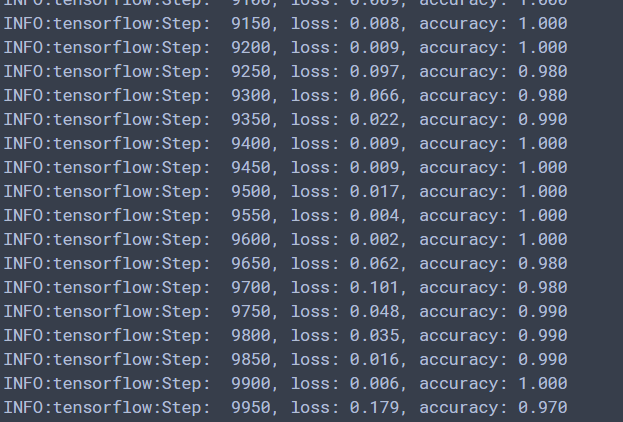